In [1]:
import pandas as pd
import numpy as np
import zipfile
import os

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.collections
import seaborn as sns

from datetime import datetime
from datetime import timedelta

import scipy.signal as scisig
from scipy import signal

In [8]:
# Importing the Blood Volume Pulse Data

list_of_columns = "BVP.csv"
zf = zipfile.ZipFile(filepath)     
data= pd.read_csv(zf.open(list_of_columns))    
    
# Get the startTime and sample rate
startTime = (pd.to_datetime(float(data.columns.values[0]),unit="s"))- timedelta(hours=6)
sampleRate = float(data.iloc[0][0])

data = data[data.index!=0]
data.index = data.index-1
data.columns = [list_of_columns]

# Timestamping the signal
data.index = pd.date_range(start=startTime, periods=len(data), freq='15.625L')
data = data.resample("15.625L").mean()
data

,BVP.csv
2022-02-15 16:39:32.000000,0.00
2022-02-15 16:39:32.015625,0.00
2022-02-15 16:39:32.031250,0.00
2022-02-15 16:39:32.046875,0.00
2022-02-15 16:39:32.062500,0.00
...,...
2022-02-17 08:01:46.921875,-146.66
2022-02-17 08:01:46.937500,-142.00
2022-02-17 08:01:46.953125,-132.38
2022-02-17 08:01:46.968750,-120.05


In [9]:
# BVP watch data is recorded at 64 Hz
len(data.loc['2022-02-15 16:39:32.000000'])

64

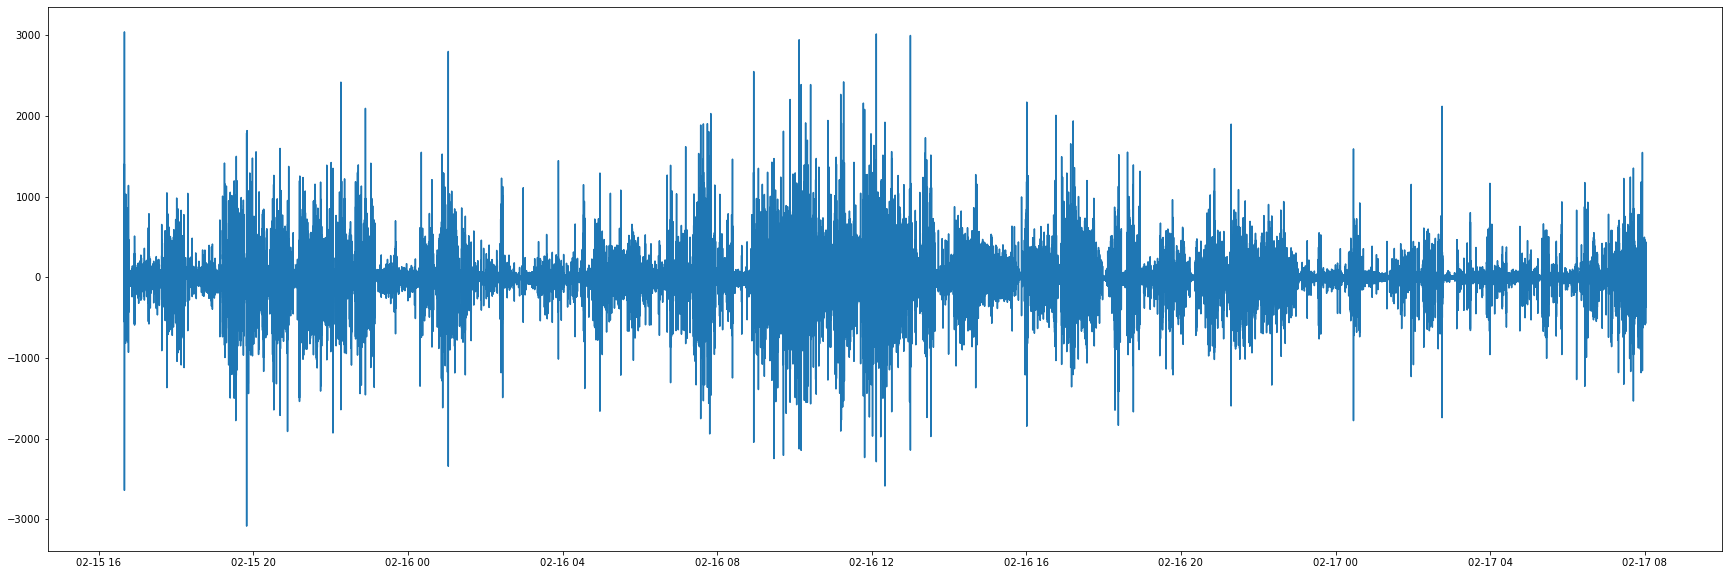

In [10]:
plt.rcParams["figure.figsize"] = (30,10)
plt.plot(data)

In [11]:
# Downsampling the signal by picking only values every 250ms

idx_range = list(range(0,len(data)))
data_4hz = data.iloc[idx_range[0::int(int(sampleRate)/4)]]
 # Set the index to be 4Hz
data_4hz.index = pd.date_range(start=startTime, periods=len(data_4hz), freq='250L')
data_4hz

,BVP.csv
2022-02-15 16:39:32.000,0.00
2022-02-15 16:39:32.250,-0.05
2022-02-15 16:39:32.500,6.20
2022-02-15 16:39:32.750,22.90
2022-02-15 16:39:33.000,93.76
...,...
2022-02-17 08:01:45.750,96.00
2022-02-17 08:01:46.000,103.19
2022-02-17 08:01:46.250,-86.64
2022-02-17 08:01:46.500,0.95


Text(0.5, 1.0, 'Downsampled Signal')

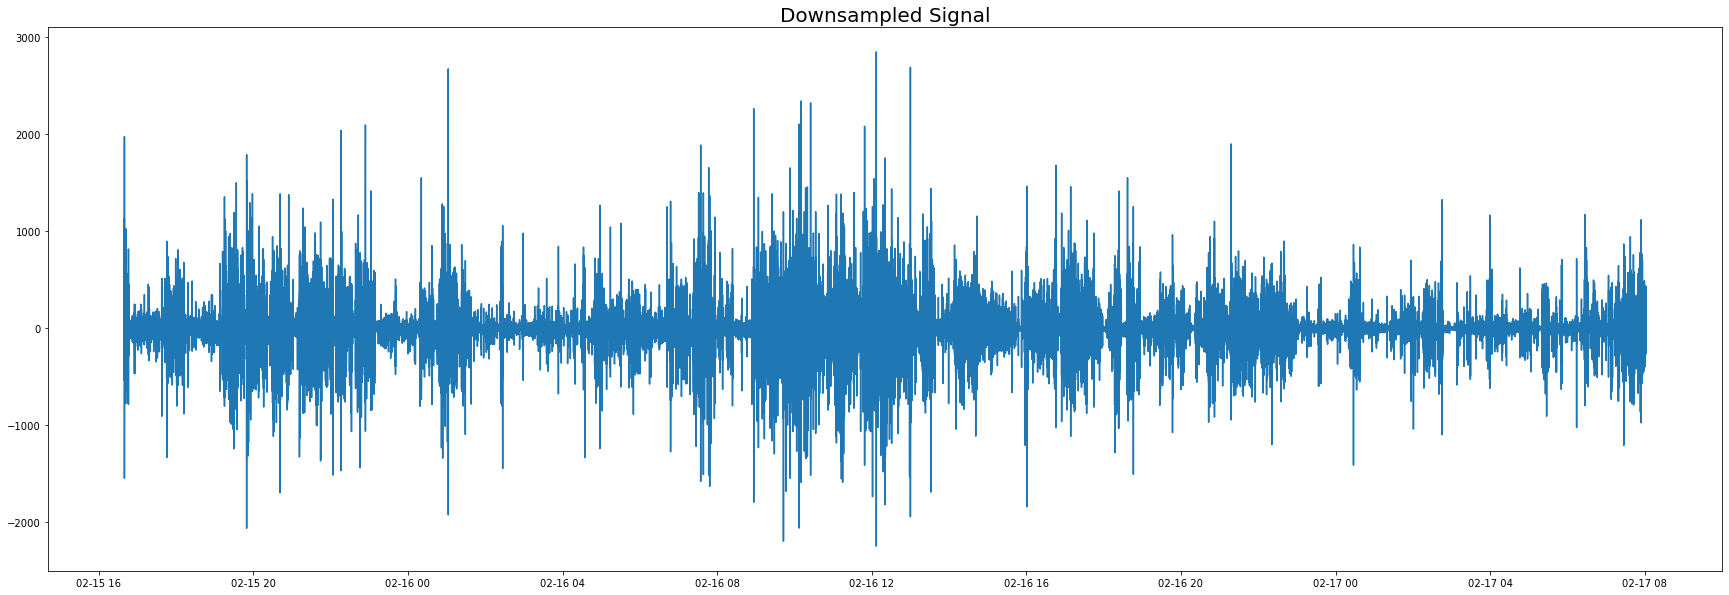

In [123]:
plt.rcParams["figure.figsize"] = (30,10)
plt.plot(data_4hz)
plt.title('Downsampled Signal', size=20)

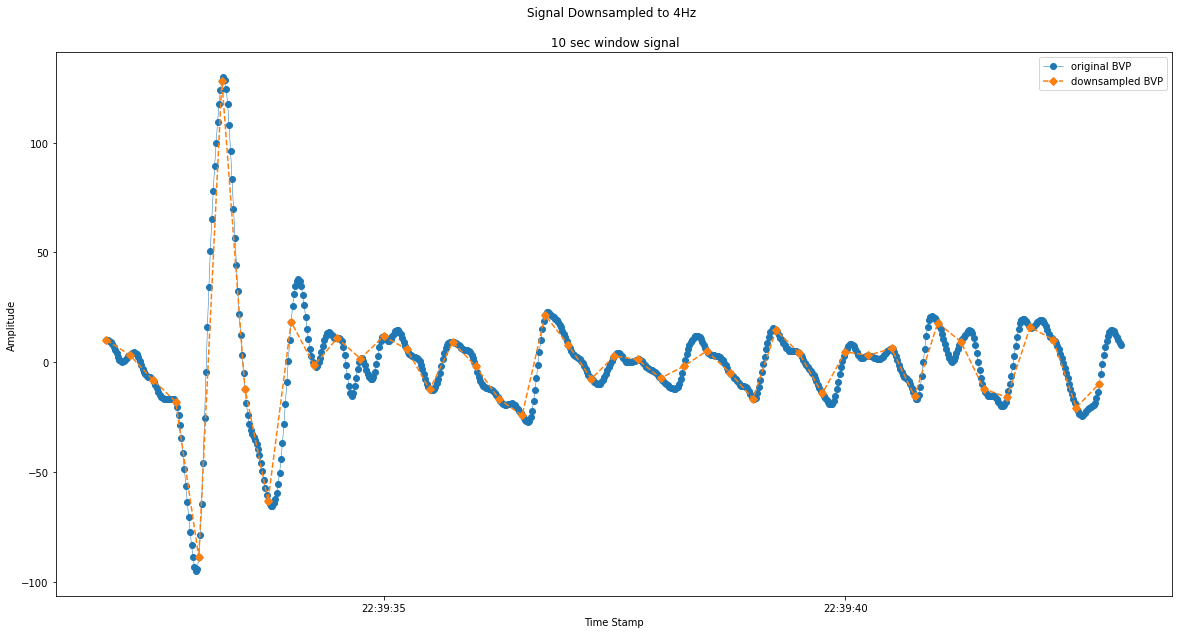

In [130]:
data1=data.loc['2022-02-15 22:39:32.000':'2022-02-15 22:39:42.000',]
data2 =data_4hz.loc['2022-02-15 22:39:32.000':'2022-02-15 22:39:42.000',]
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data1,marker='o', linestyle='-', linewidth=0.5, label='original BVP')
ax.plot(data2,marker='D', linestyle='--', label='downsampled BVP')
ax.set_ylabel('Amplitude')
ax.set_title('Signal Downsampled to 4Hz \n\n 10 sec window signal')
ax.set_xlabel('Time Stamp')
ax.legend()
plt.show()

## Downsample the signal after applying an anti-aliasing filter.


### scipy.signal.decimate(x, q, n=None, ftype='iir', axis=- 1, zero_phase=True)

##### Downsample the signal after applying an anti-aliasing filter.

By default, an order 8 Chebyshev type I filter is used. A 30 point FIR filter with Hamming window is used if ftype is ‘fir’.

Parameters

#####  xarray_like

The signal to be downsampled, as an N-dimensional array.

#####  q int

The downsampling factor. When using IIR downsampling, it is recommended to call decimate multiple times for downsampling factors higher than 13.

#####  n int, optional

The order of the filter (1 less than the length for ‘fir’). Defaults to 8 for ‘iir’ and 20 times the downsampling factor for ‘fir’.

#####  ftypestr {‘iir’, ‘fir’} or dlti instance, optional

If ‘iir’ or ‘fir’, specifies the type of lowpass filter. If an instance of an dlti object, uses that object to filter before downsampling.

#####  axis int, optional

The axis along which to decimate.

#####  zero_phase bool, optional

Prevent phase shift by filtering with filtfilt instead of lfilter when using an IIR filter, and shifting the outputs back by the filter’s group delay when using an FIR filter. The default value of True is recommended, since a phase shift is generally not desired.

In [64]:
data1_resampled = signal.decimate(data['BVP.csv'], 16, n=None, ftype='fir', axis=- 1, zero_phase=True)

In [67]:
data1_resampled_df= pd.DataFrame()

data1_resampled_df.index = pd.date_range(start=startTime, periods=len(data1_resampled), freq='250L')

data1_resampled_df['BVP_4hz']=data1_resampled

data1_resampled_df

,BVP_4hz
2022-02-15 16:39:32.000,1.771361
2022-02-15 16:39:32.250,-2.235964
2022-02-15 16:39:32.500,9.412663
2022-02-15 16:39:32.750,16.033908
2022-02-15 16:39:33.000,111.690808
...,...
2022-02-17 08:01:45.750,137.917815
2022-02-17 08:01:46.000,49.678224
2022-02-17 08:01:46.250,-101.267402
2022-02-17 08:01:46.500,37.279994


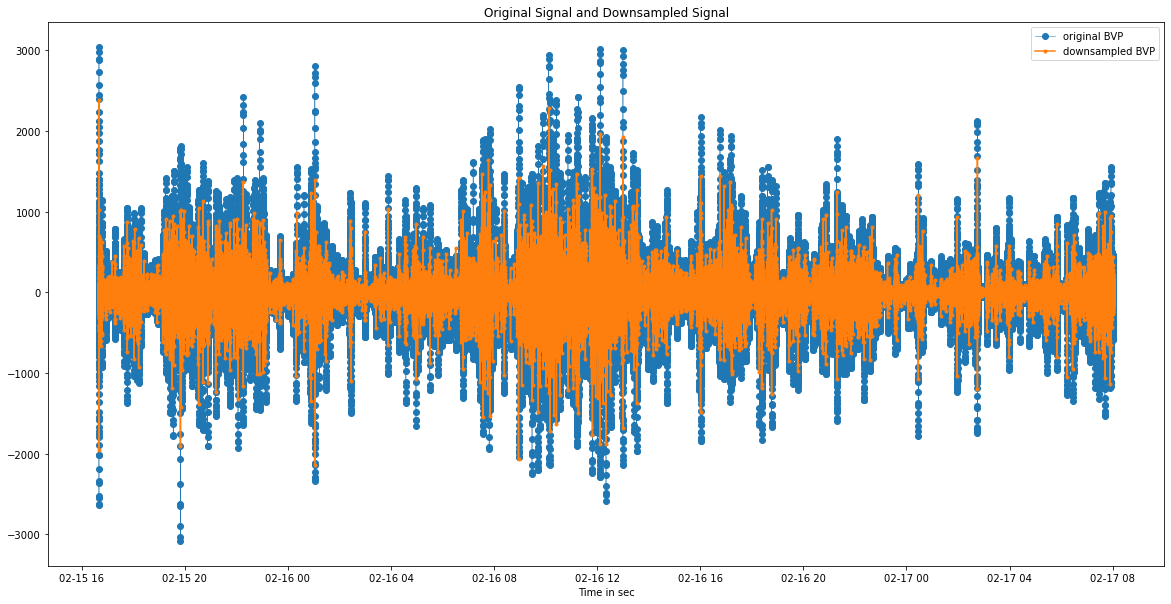

In [131]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data,marker='o', linestyle='-', linewidth=0.5, label='original BVP')
ax.plot(data1_resampled_df,marker='.', linestyle='-', label='downsampled BVP')
ax.set_xlabel('Time in sec')
ax.set_title('Original Signal and Downsampled Signal')
ax.legend()
plt.show()

#### Data - 10 sec window  22:39:32 - 22:39:42

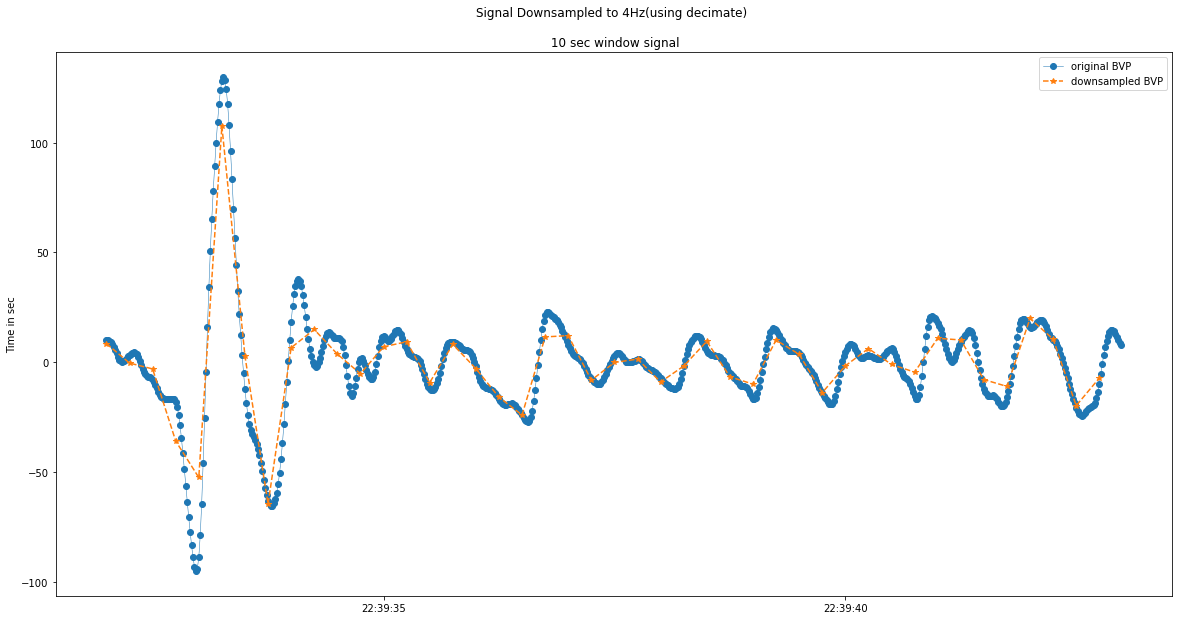

In [133]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data.loc['2022-02-15 22:39:32.000':'2022-02-15 22:39:42.000'],marker='o', linestyle='-', linewidth=0.5, label='original BVP')
ax.plot(data1_resampled_df.loc['2022-02-15 22:39:32.000':'2022-02-15 22:39:42.000'],marker='*', linestyle='--', label='downsampled BVP')
ax.set_ylabel('Time in sec')
ax.set_title('Signal Downsampled to 4Hz(using decimate) \n\n 10 sec window signal')
ax.legend()
plt.show()

## Spectral Analysis

In [70]:
from scipy.fftpack import fft

In [102]:
# 10 min window of Original signal 
data.loc['2022-02-15 22:39:32.000':'2022-02-15 22:49:42.000']

,BVP.csv
2022-02-15 22:39:32.000000,10.13
2022-02-15 22:39:32.015625,10.16
2022-02-15 22:39:32.031250,9.84
2022-02-15 22:39:32.046875,9.22
2022-02-15 22:39:32.062500,8.27
...,...
2022-02-15 22:49:42.921875,-18.59
2022-02-15 22:49:42.937500,-18.59
2022-02-15 22:49:42.953125,-17.00
2022-02-15 22:49:42.968750,-14.07


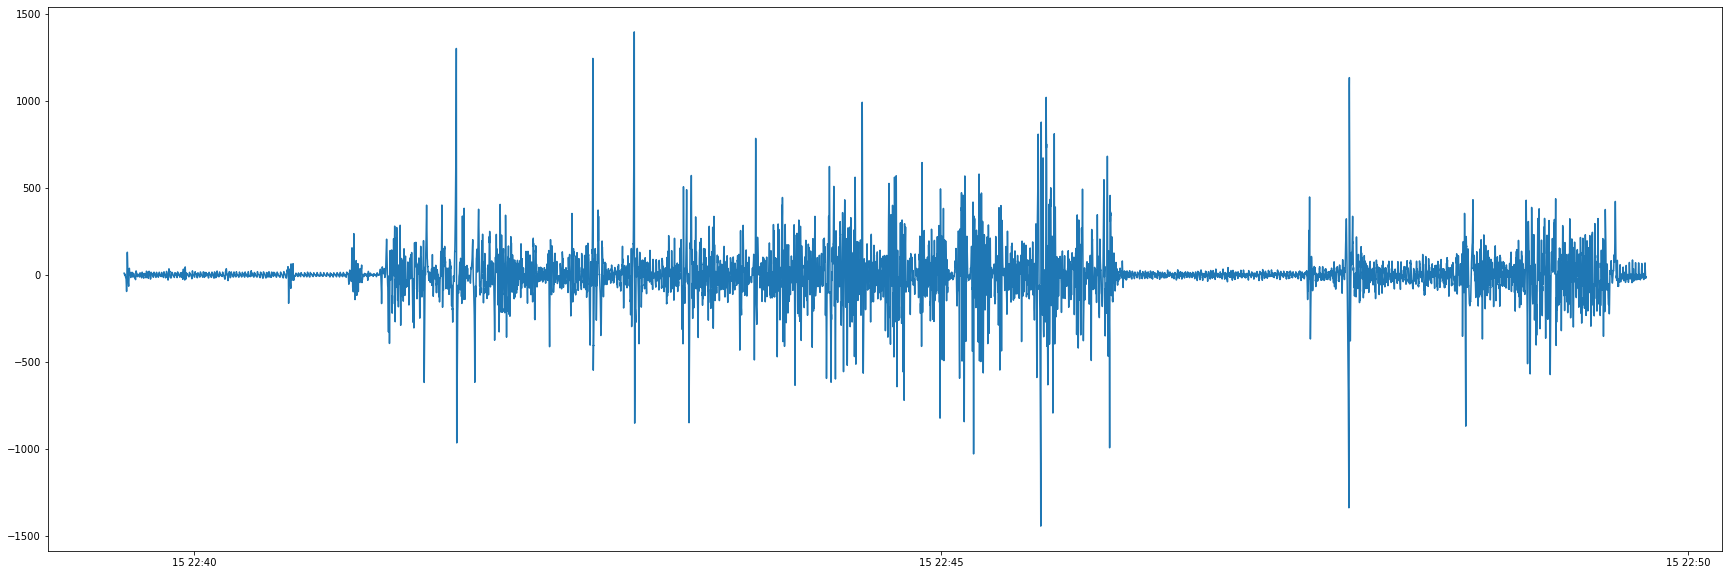

In [110]:
plt.plot(data.loc['2022-02-15 22:39:32.000':'2022-02-15 22:49:42.000'])

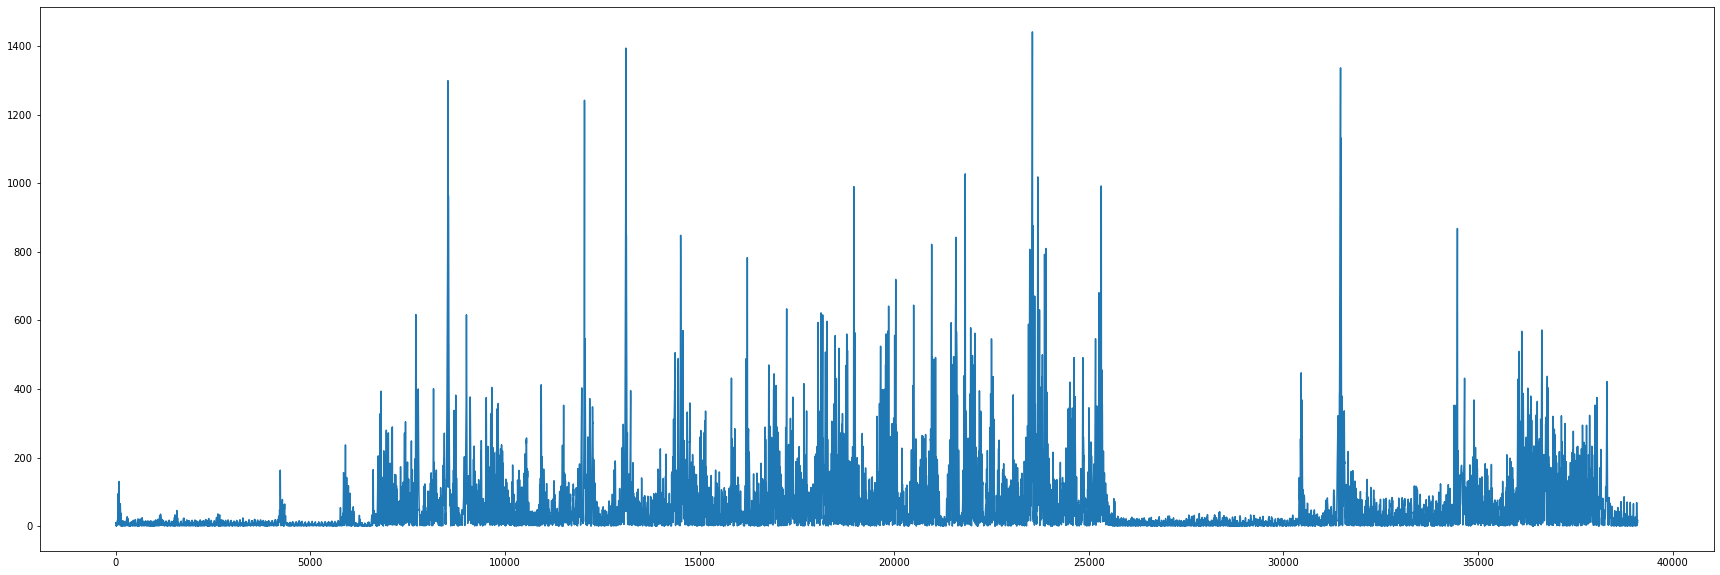

In [137]:
# Compute FFT 
X = fft(data.loc['2022-02-15 22:39:32.000':'2022-02-15 22:49:42.000'])

Fs = 64
t = np.arange(0,1,1/Fs)

plt.plot(abs(X))

In [138]:
# generate frequency axis
n = np.size(data.loc['2022-02-15 22:39:32.000':'2022-02-15 22:49:42.000'].index)

n

39104

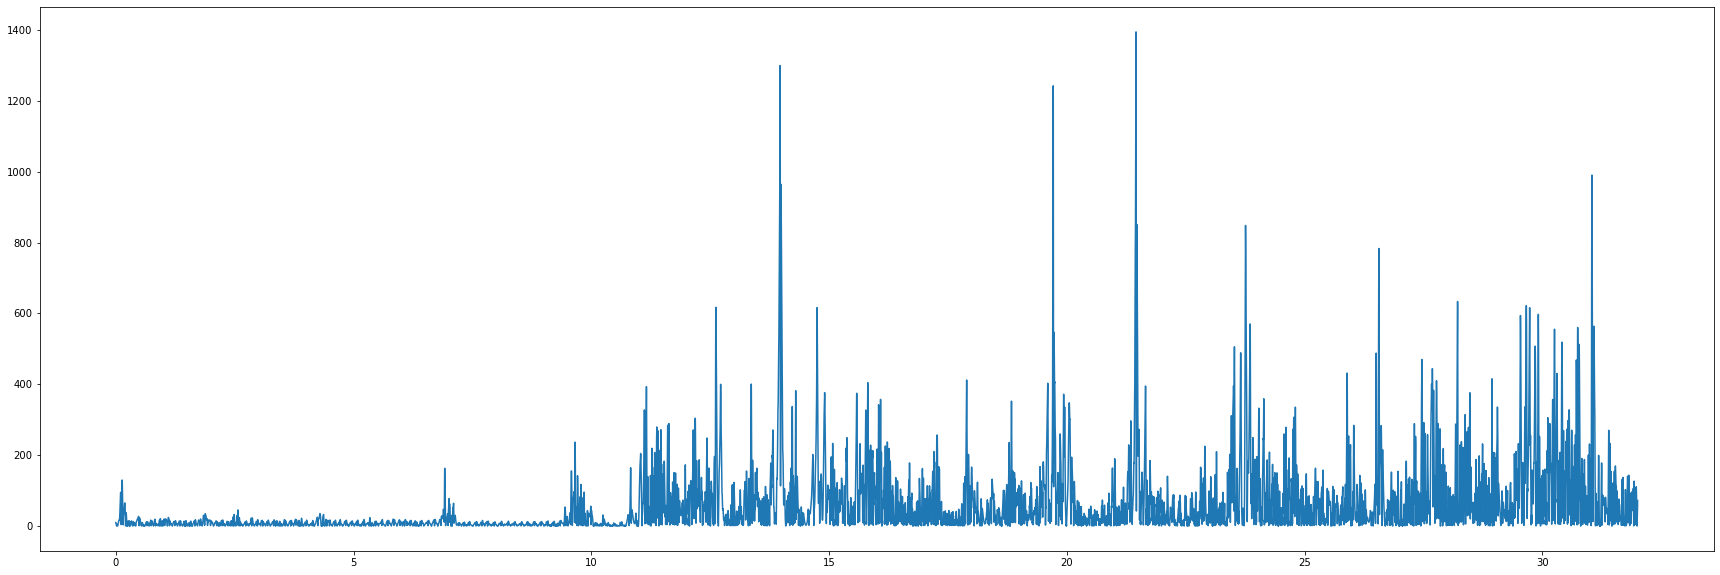

In [139]:
fr = (Fs/2)*np.linspace(0,1,int(n/2))

# magnitude
X_m = abs(X[0:np.size(fr)])
plt.plot(fr,X_m)

Text(0, 0.5, 'Amplitude')

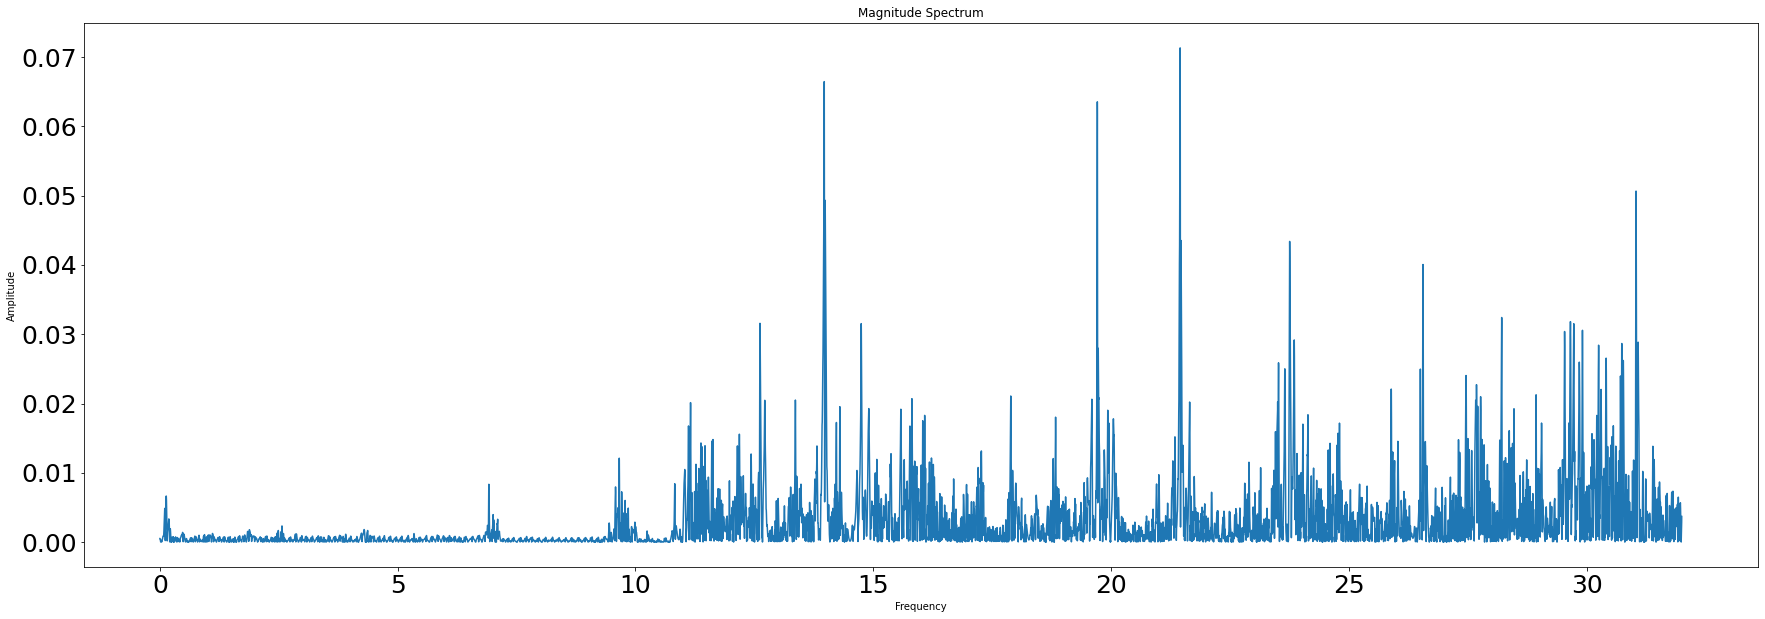

In [120]:

# magnitude
X_m = (2/n)*abs(X[0:np.size(fr)])
plt.plot(fr,X_m)
plt.title('Magnitude Spectrum')
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

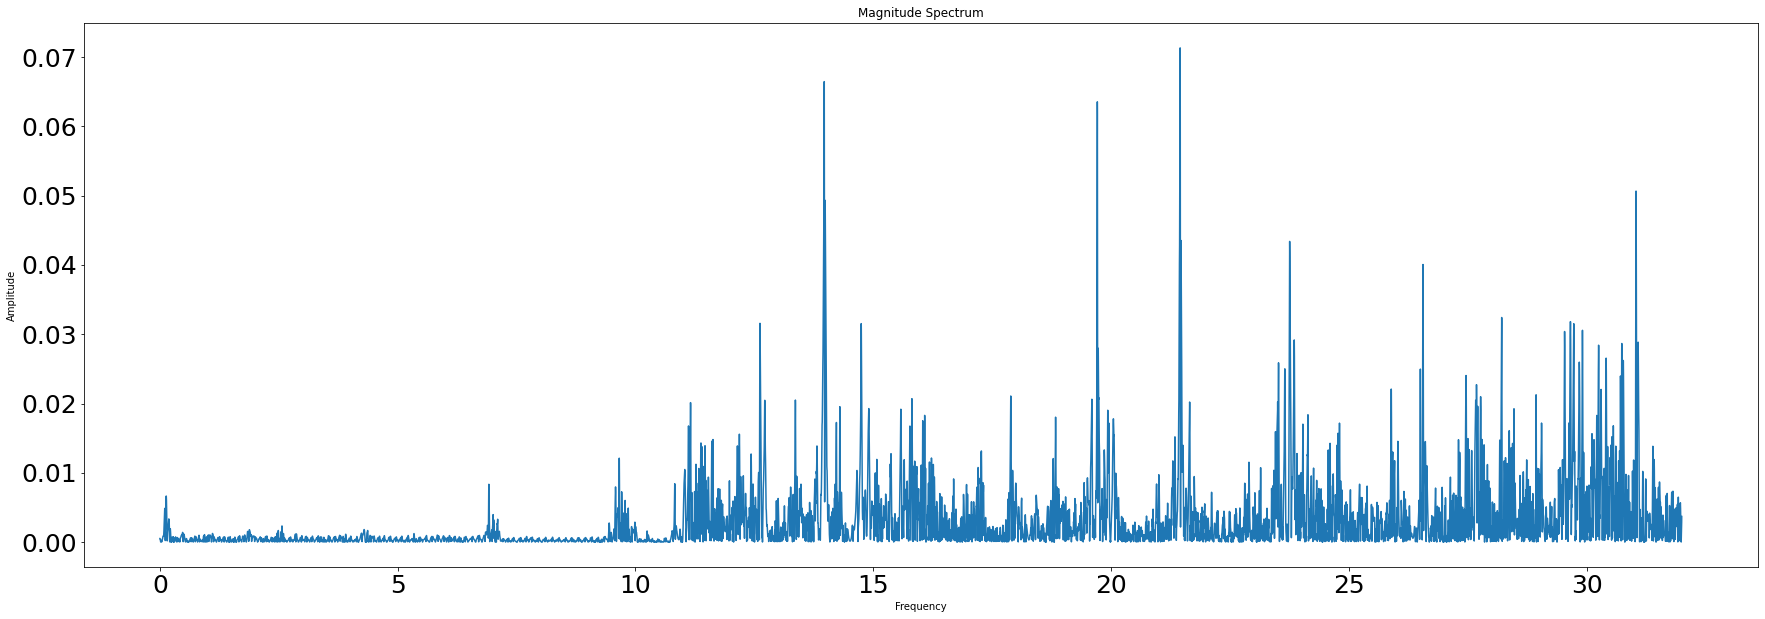

In [150]:
# FFT of original data
# Compute FFT 
X0 = fft(data.loc['2022-02-15 22:39:32.000':'2022-02-15 22:49:42.000'])
# generate frequency axis
n0 = np.size(data.loc['2022-02-15 22:39:32.000':'2022-02-15 22:49:42.000'].index)

Fs0 = 64
t0 = np.arange(0,1,1/Fs0)

# generate frequency axis
n0 = np.size(data.loc['2022-02-15 22:39:32.000':'2022-02-15 22:49:42.000'].index)

fr0 = (Fs0/2)*np.linspace(0,1,int(n0/2))

# magnitude
X_m0 = (2/n0)*abs(X[0:np.size(fr0)])

plt.plot(fr0,X_m0)

plt.title('Magnitude Spectrum')
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

In [135]:
# downsampled data - picking 250ms data point

data_4hz.loc['2022-02-15 22:39:32.000':'2022-02-15 22:49:42.000']

,BVP.csv
2022-02-15 22:39:32.000,10.13
2022-02-15 22:39:32.250,3.36
2022-02-15 22:39:32.500,-7.88
2022-02-15 22:39:32.750,-18.01
2022-02-15 22:39:33.000,-88.83
...,...
2022-02-15 22:49:41.750,-6.88
2022-02-15 22:49:42.000,-0.50
2022-02-15 22:49:42.250,-15.98
2022-02-15 22:49:42.500,11.69


Text(0, 0.5, 'Amplitude')

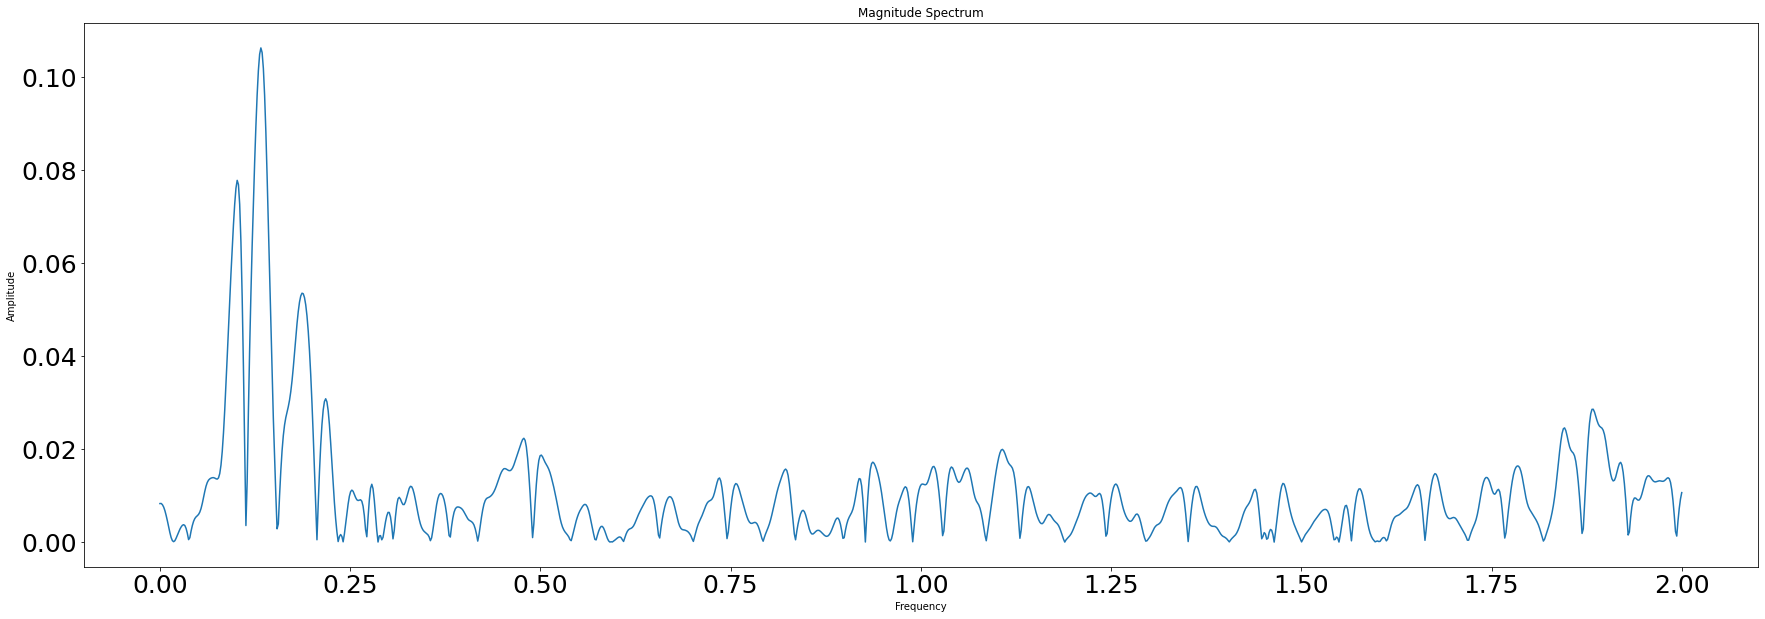

In [143]:
# FFT of downsampled data
# Compute FFT 
X1 = fft(data_4hz.loc['2022-02-15 22:39:32.000':'2022-02-15 22:49:42.000'])
# generate frequency axis
n1 = np.size(data_4hz.loc['2022-02-15 22:39:32.000':'2022-02-15 22:49:42.000'].index)

Fs1 = 4
t1 = np.arange(0,1,1/Fs1)

# generate frequency axis
n1 = np.size(data_4hz.loc['2022-02-15 22:39:32.000':'2022-02-15 22:49:42.000'].index)

fr1 = (Fs1/2)*np.linspace(0,1,int(n1/2))

# magnitude
X_m1 = (2/n1)*abs(X[0:np.size(fr1)])
plt.plot(fr1,X_m1)
plt.title('Magnitude Spectrum')
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')


Text(0, 0.5, 'Amplitude')

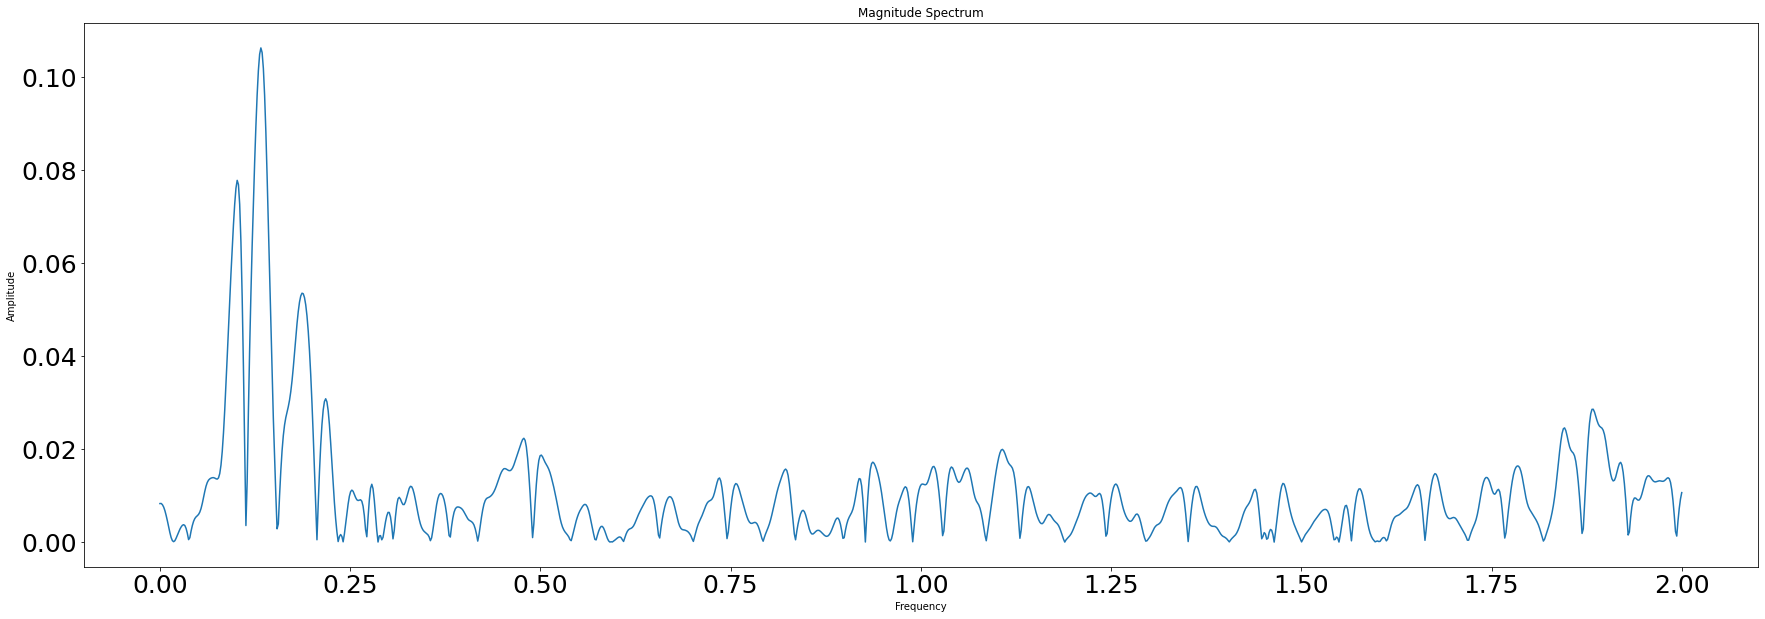

In [144]:
# FFT of downsampled data using antialias filter and decimate
# Compute FFT 
X2 = fft(data1_resampled_df.loc['2022-02-15 22:39:32.000':'2022-02-15 22:49:42.000'])
# generate frequency axis
n2 = np.size(data1_resampled_df.loc['2022-02-15 22:39:32.000':'2022-02-15 22:49:42.000'].index)

Fs2 = 4
t2 = np.arange(0,1,1/Fs2)

# generate frequency axis
n2 = np.size(data1_resampled_df.loc['2022-02-15 22:39:32.000':'2022-02-15 22:49:42.000'].index)

fr2 = (Fs2/2)*np.linspace(0,1,int(n2/2))

# magnitude
X_m2 = (2/n2)*abs(X[0:np.size(fr2)])

plt.plot(fr2,X_m2)

plt.title('Magnitude Spectrum')
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')


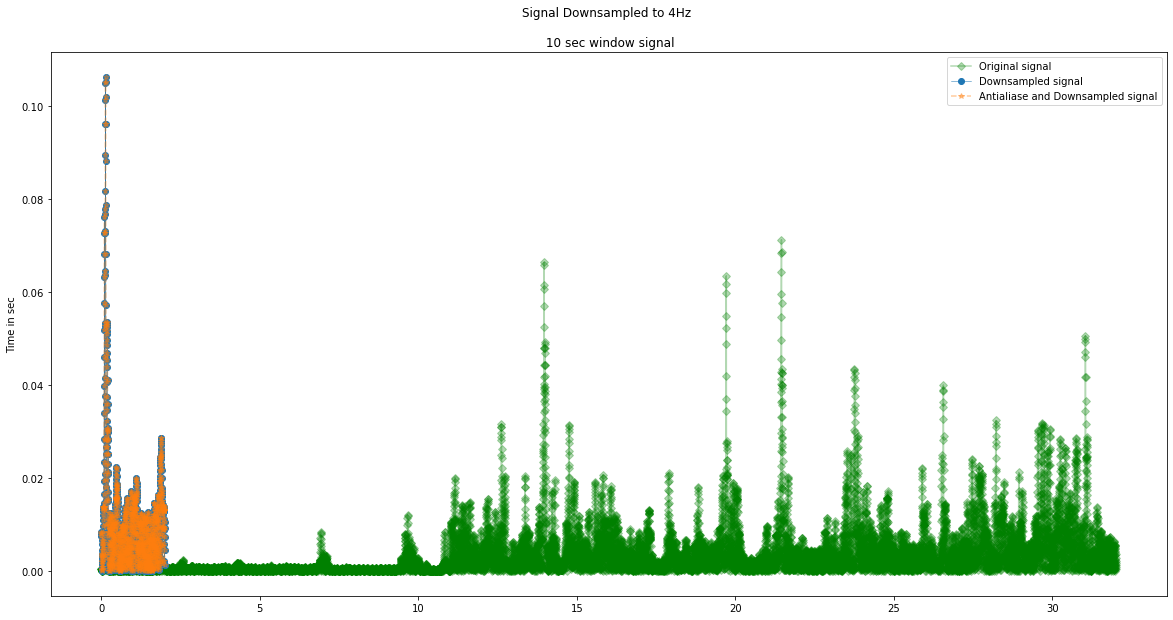

In [154]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(fr0,X_m0,marker='D', label='Original signal',color="green", alpha=0.3)

ax.plot(fr1,X_m1,marker='o', linestyle='-', linewidth=0.5, label='Downsampled signal')
ax.plot(fr2,X_m2,marker='*', linestyle='--', label='Antialiase and Downsampled signal',alpha=0.4)

ax.set_ylabel('Time in sec')
ax.set_title('Signal Downsampled to 4Hz \n\n 10 sec window signal')
ax.legend()
plt.show()

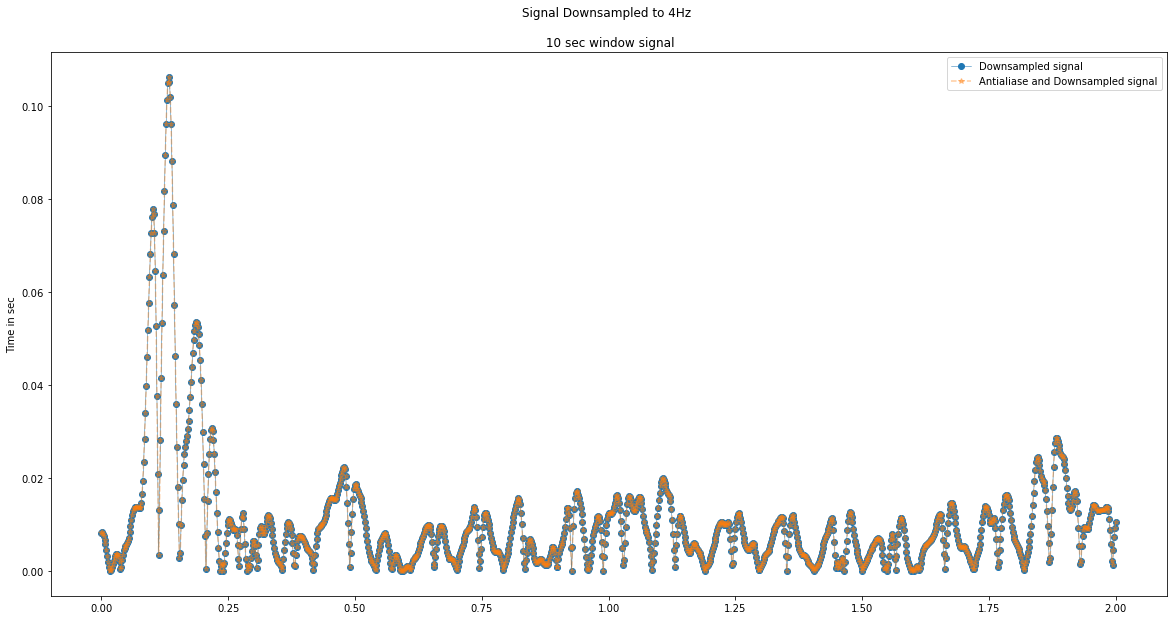

In [155]:
fig, ax = plt.subplots(figsize=(20,10))
# ax.plot(fr0,X_m0,marker='D', label='Original signal',color="green", alpha=0.3)

ax.plot(fr1,X_m1,marker='o', linestyle='-', linewidth=0.5, label='Downsampled signal')
ax.plot(fr2,X_m2,marker='*', linestyle='--', label='Antialiase and Downsampled signal',alpha=0.4)

ax.set_ylabel('Time in sec')
ax.set_title('Signal Downsampled to 4Hz \n\n 10 sec window signal')
ax.legend()
plt.show()